<a href="https://colab.research.google.com/github/IHD26/ECOMMERCE-DJANGO/blob/main/Copie_de_how_to_finetune_paligemma2_on_detection_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tune PaliGemma2 on Object Detection Dataset

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/google-research/big_vision/blob/main/big_vision/configs/proj/paligemma/README.md)
[![arXiv](https://img.shields.io/badge/arXiv-2412.03555-b31b1b.svg)](https://arxiv.org/abs/2412.03555)

PaliGemma 2 is built by combining the SigLIP-So400m vision encoder with the more recent and capable language models from the Gemma 2 family.

![PaliGemma2 Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-1.png)

The authors use a 3-stage training approach similar to the original PaliGemma. In stage 1, they combine the pretrained vision and language model components and train them jointly on a multimodal task mixture. In stage 2, they train the models at higher resolutions of 448px^2 and 896px^2. In stage 3, they fine-tune the models on the target transfer tasks.

PaliGemma 2 models outperform the original PaliGemma at the same resolution and model size. Increasing the model size and resolution generally improves performance across a wide range of tasks, but the benefits differ depending on the task. Some tasks benefit more from increased resolution, while others benefit more from a larger language model.

![PaliGemma2 Figure.2](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/paligemma2-2.png)

Notebook requires A100 with 40GB of VRAM to train.

## Setup

### Configure your API keys

To fine-tune PaliGemma2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [3]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


### Download dataset from Roboflow Universe

To fine-tune PaliGemma2, prepare your dataset in JSONL format. You can use Roboflow to easily convert any dataset into this format.

In [4]:
!pip install -q roboflow supervision peft bitsandbytes transformers==4.47.0

In [5]:


from google.colab import userdata
from roboflow import Roboflow


rf = Roboflow(api_key="6tXrMtZ7zJAephsBmo3A")
project = rf.workspace("machinelearning-p49ei").project("gc10-det-dataset")
version = project.version(4)
dataset = version.download("paligemma")

loading Roboflow workspace...
loading Roboflow project...


**NOTE:** Let's read the first few lines of the annotation file and examine the dataset format.

In [6]:
!head -n 5 {dataset.location}/dataset/_annotations.train.jsonl

{"image":"img_01_425005700_00440_jpg.rf.68b53584c9ee975b33901a72b1a7fad3.jpg","prefix":"detect crease ; crescent_gap ; inclusion ; oil_spot ; punching_hole ; rolled_pit ; silk_spot ; waist_folding ; water_spot ; welding_line","suffix":"<loc0055><loc0410><loc0807><loc0662> silk_spot"}
{"image":"img_01_425005700_00312_jpg.rf.59d620775dc48e878a9bd9d2ae13b114.jpg","prefix":"detect crease ; crescent_gap ; inclusion ; oil_spot ; punching_hole ; rolled_pit ; silk_spot ; waist_folding ; water_spot ; welding_line","suffix":"<loc0000><loc0434><loc0849><loc0711> silk_spot"}
{"image":"img_01_425005700_00286_jpg.rf.2794892e31655fa1e2ef419dcf825c99.jpg","prefix":"detect crease ; crescent_gap ; inclusion ; oil_spot ; punching_hole ; rolled_pit ; silk_spot ; waist_folding ; water_spot ; welding_line","suffix":"<loc0044><loc0385><loc0867><loc0640> silk_spot"}
{"image":"img_06_3403405000_00719_jpg.rf.062125c73760d2958383583e92911e0d.jpg","prefix":"detect crease ; crescent_gap ; inclusion ; oil_spot ; pu

### Set up and test data loaders

In [7]:
import os
import json
import random
from PIL import Image
from torch.utils.data import Dataset


class JSONLDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        image = Image.open(image_path)
        return image, entry

In [8]:
train_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/dataset/_annotations.train.jsonl",
    image_directory_path=f"{dataset.location}/dataset",
)
valid_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/dataset/_annotations.valid.jsonl",
    image_directory_path=f"{dataset.location}/dataset",
)
test_dataset = JSONLDataset(
    jsonl_file_path=f"{dataset.location}/dataset/_annotations.test.jsonl",
    image_directory_path=f"{dataset.location}/dataset",
)

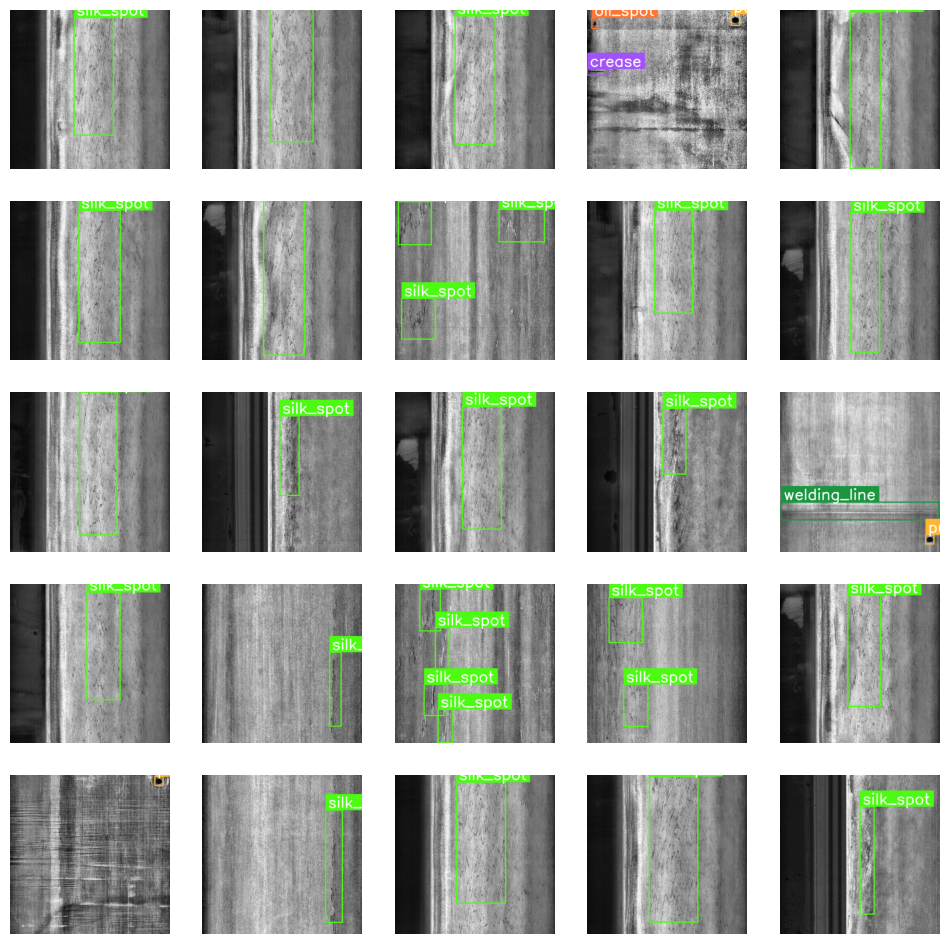

In [9]:
from tqdm import tqdm
import supervision as sv


CLASSES = train_dataset[0][1]['prefix'].replace("detect ", "").split(" ; ")

images = []
for i in range(25):
    image, label = train_dataset[i]
    detections = sv.Detections.from_lmm(
        lmm='paligemma',
        result=label["suffix"],
        resolution_wh=(image.width, image.height),
        classes=CLASSES)

    image = sv.BoxAnnotator(thickness=4).annotate(image, detections)
    image = sv.LabelAnnotator(text_scale=2, text_thickness=4).annotate(image, detections)
    images.append(image)

sv.plot_images_grid(images, (5, 5))

### Load PaliGemma2 model

**NOTE:** PaliGemma2 offers 9 pre-trained models with sizes of `3B`, `10B`, and `28B` parameters, and resolutions of `224`, `448`, and `896` pixels. In this tutorial, I'll be using the [`google/paligemma2-3b-pt-448`](https://huggingface.co/google/paligemma2-3b-pt-448) checkpoint. Resolution has a key impact on the mAP of the trained model, and it seems that `448` offers the most optimal balance between performance and compute resources required to train the model.

In [10]:
import torch
from transformers import PaliGemmaProcessor, PaliGemmaForConditionalGeneration

MODEL_ID ="google/paligemma2-3b-pt-448"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
from huggingface_hub import notebook_login
notebook_login()

In [12]:
processor = PaliGemmaProcessor.from_pretrained(MODEL_ID)

The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


**NOTE:** Depending on the multimodal task you are trying to solve, we have prepared two training versions that optimize VRAM consumption.

- Freeze the image encoder and fine-tune only the text decoder.
- Fine-tune the entire model with LoRA and QLoRA.

In [13]:
# @title Freeze the image encoder


TORCH_DTYPE = torch.bfloat16

model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, torch_dtype=TORCH_DTYPE).to(DEVICE)

for param in model.vision_tower.parameters():
    param.requires_grad = False

for param in model.multi_modal_projector.parameters():
    param.requires_grad = False

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [14]:
# @title Fine-tune the entire model with LoRA and QLoRA

# from transformers import BitsAndBytesConfig
# from peft import get_peft_model, LoraConfig

# bnb_config = BitsAndBytesConfig(
#     load_in_4bit=True,
#     bnb_4bit_compute_dtype=torch.bfloat16
# )

# lora_config = LoraConfig(
#     r=8,
#     target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
#     task_type="CAUSAL_LM",
# )

# model = PaliGemmaForConditionalGeneration.from_pretrained(MODEL_ID, device_map="auto")
# model = get_peft_model(model, lora_config)
# model.print_trainable_parameters()

# TORCH_DTYPE = model.dtype

### Fine-tune PaliGemma2 on custom object detection dataset

In [15]:
from transformers import Trainer, TrainingArguments


def augment_suffix(suffix):
    parts = suffix.split(' ; ')
    random.shuffle(parts)
    return ' ; '.join(parts)


def collate_fn(batch):
    images, labels = zip(*batch)

    paths = [label["image"] for label in labels]
    prefixes = ["<image>" + label["prefix"] for label in labels]
    suffixes = [augment_suffix(label["suffix"]) for label in labels]

    inputs = processor(
        text=prefixes,
        images=images,
        return_tensors="pt",
        suffix=suffixes,
        padding="longest"
    ).to(TORCH_DTYPE).to(DEVICE)

    return inputs

args = TrainingArguments(
    num_train_epochs=16,
    remove_unused_columns=False,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=16,
    warmup_steps=2,
    learning_rate=2e-5,
    weight_decay=1e-6,
    adam_beta2=0.999,
    logging_steps=50,
    optim="adamw_hf",
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=1,
    output_dir="paligemma2_object_detection",
    bf16=True,
    report_to=["tensorboard"],
    dataloader_pin_memory=False
)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    data_collator=collate_fn,
    args=args
)

In [ ]:
trainer.train()

### Run inference with fine-tuned PaliGemma2 model

The 'batch_size' attribute of HybridCache is deprecated and will be removed in v4.49. Use the more precisely named 'self.max_batch_size' attribute instead.


<loc0504><loc0430><loc0882><loc0815> 6 of clubs ; <loc0102><loc0482><loc0416><loc0840> 7 of clubs ; <loc0159><loc0180><loc0499><loc0486> 8 of clubs ; <loc0476><loc0102><loc0820><loc0424> 5 of clubs ; 


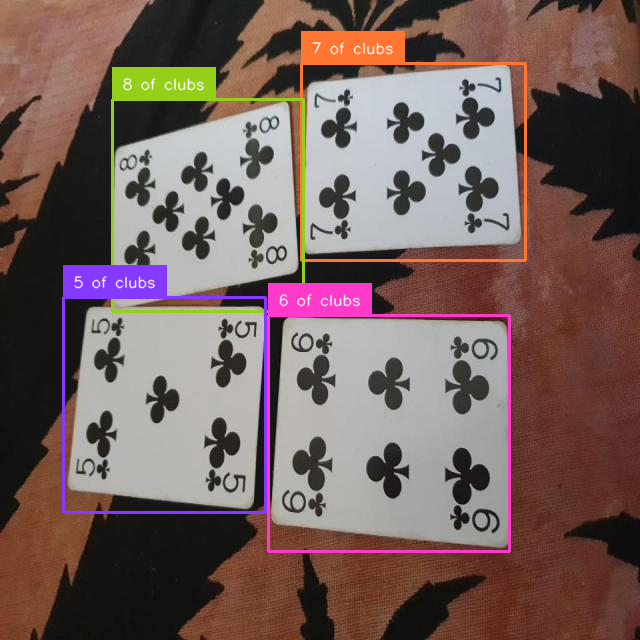

In [ ]:
image, label = test_dataset[1]
prefix = "<image>" + label["prefix"]
suffix = label["suffix"]

inputs = processor(
    text=prefix,
    images=image,
    return_tensors="pt"
).to(TORCH_DTYPE).to(DEVICE)

prefix_length = inputs["input_ids"].shape[-1]

with torch.inference_mode():
    generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
    generation = generation[0][prefix_length:]
    decoded = processor.decode(generation, skip_special_tokens=True)
    print(decoded)

w, h = image.size
detections = sv.Detections.from_lmm(
    lmm='paligemma',
    result=decoded,
    resolution_wh=(w, h),
    classes=CLASSES)

annotated_image = image.copy()
annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
annotated_image = sv.LabelAnnotator(smart_position=True).annotate(annotated_image, detections)
annotated_image

### Evaluate fine-tuned PaliGemma2 model

In [ ]:
import numpy as np
from tqdm import tqdm

images = []
targets = []
predictions = []

with torch.inference_mode():
    for i in tqdm(range(len(test_dataset))):
        image, label = test_dataset[i]
        prefix = "<image>" + label["prefix"]
        suffix = label["suffix"]

        inputs = processor(
            text=prefix,
            images=image,
            return_tensors="pt"
        ).to(TORCH_DTYPE).to(DEVICE)

        prefix_length = inputs["input_ids"].shape[-1]

        generation = model.generate(**inputs, max_new_tokens=256, do_sample=False)
        generation = generation[0][prefix_length:]
        generated_text = processor.decode(generation, skip_special_tokens=True)

        w, h = image.size
        prediction = sv.Detections.from_lmm(
            lmm='paligemma',
            result=generated_text,
            resolution_wh=(w, h),
            classes=CLASSES)

        prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
        prediction.confidence = np.ones(len(prediction))

        target = sv.Detections.from_lmm(
            lmm='paligemma',
            result=suffix,
            resolution_wh=(w, h),
            classes=CLASSES)

        target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])

        images.append(image)
        targets.append(target)
        predictions.append(prediction)

100%|██████████| 44/44 [04:59<00:00,  6.80s/it]


In [ ]:
# @title Calculate mAP

from supervision.metrics import MeanAveragePrecision, MetricTarget

map_metric = MeanAveragePrecision(metric_target=MetricTarget.BOXES)
map_result = map_metric.update(predictions, targets).compute()

print(map_result)

MeanAveragePrecisionResult:
Metric target: MetricTarget.BOXES
Class agnostic: False
mAP @ 50:95: 0.6246
mAP @ 50:    0.7164
mAP @ 75:    0.6904
mAP scores: [0.7163872  0.71120399 0.69792334 0.69563849 0.69563849 0.69043413
 0.67398688 0.63946382 0.52168119 0.20399485]
IoU thresh: [0.5  0.55 0.6  0.65 0.7  0.75 0.8  0.85 0.9  0.95]
AP per class:
  0: [1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.60808581]
  1: [0.5049505  0.5049505  0.5049505  0.5049505  0.5049505  0.5049505
 0.5049505  0.5049505  0.5049505  0.25742574]
  2: [0.82791136 0.82791136 0.82791136 0.82791136 0.82791136 0.82791136
 0.82791136 0.82791136 0.24988213 0.0330033 ]
  3: [0.66336634 0.66336634 0.66336634 0.66336634 0.66336634 0.66336634
 0.66336634 0.66336634 0.66336634 0.16336634]
  4: [1.        1.        1.        1.        1.        1.        1.
 1.        1.        0.5049505]
  5: [1. 1. 1. 1. 1. 1. 1. 1. 1. 0.]
  6: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  7: [0.8069306

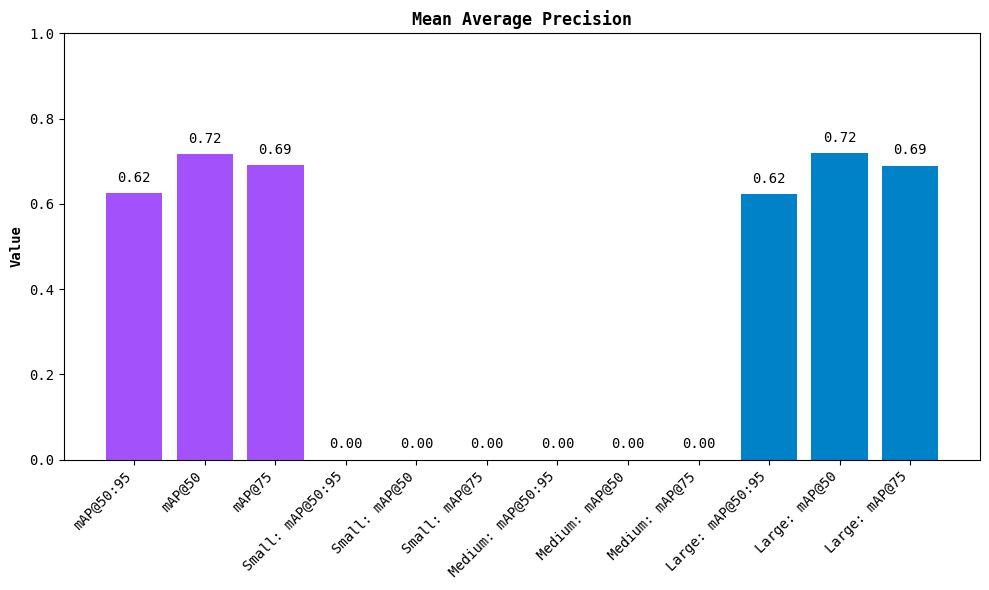

In [ ]:
map_result.plot()

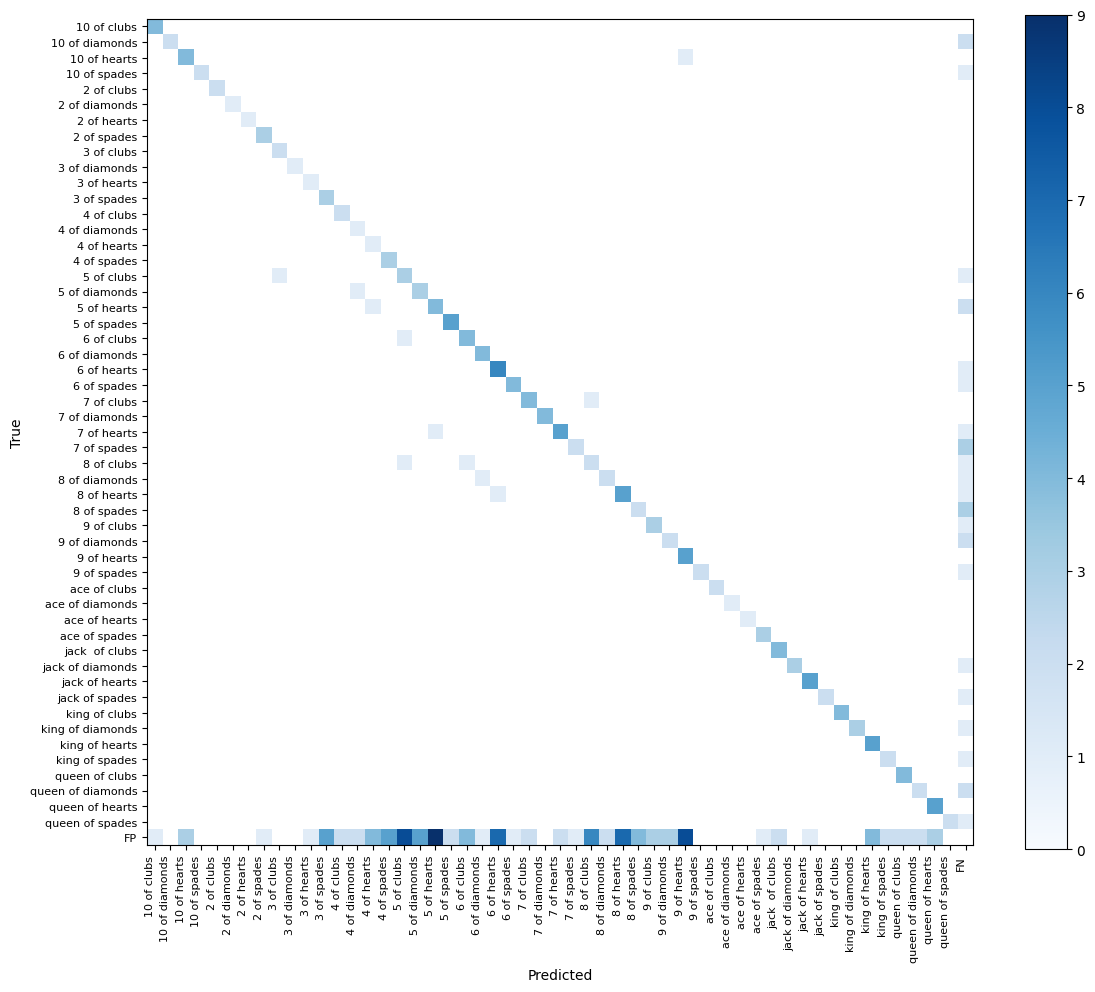

In [ ]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

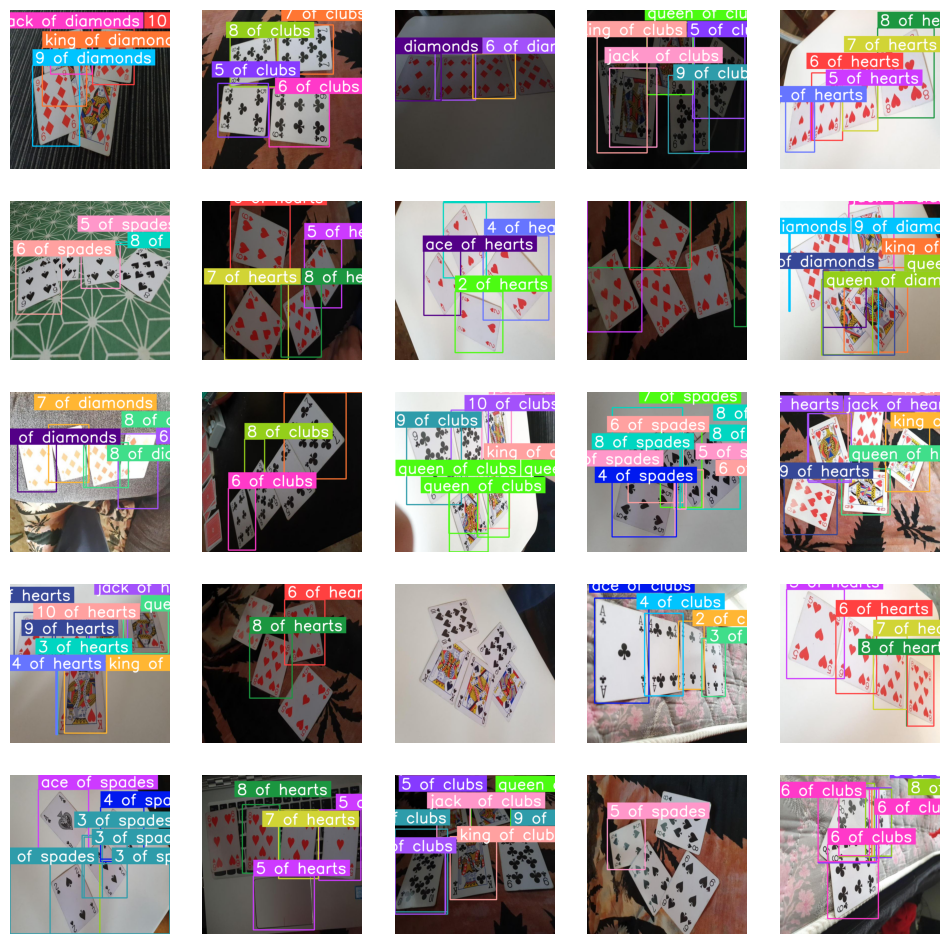

In [ ]:
annotated_images = []

for i in range(25):
    image = images[i]
    detections = predictions[i]

    annotated_image = image.copy()
    annotated_image = sv.BoxAnnotator(thickness=4).annotate(annotated_image, detections)
    annotated_image = sv.LabelAnnotator(text_scale=2, text_thickness=4, smart_position=True).annotate(annotated_image, detections)
    annotated_images.append(annotated_image)

sv.plot_images_grid(annotated_images, (5, 5))